In [1]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils import plot, get_time_series
%matplotlib inline

np.random.seed(14)

/home/ekvall/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ls "assets/"

rspb20170679_si_005.csv


In [3]:
df = pd.read_csv("assets/rspb20170679_si_005.csv")

df.columns = ["Year","Pencillin(R)", "Erythromycin(R)","Multidrug(R)","Amoxicillin(C)",
              "Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)","Cephalosporins(C)",
              "Azithromycin(C)","ConcTotal(C)"]
df = df.set_index("Year")
df.head(2)

,Pencillin(R),Erythromycin(R),Multidrug(R),Amoxicillin(C),Amoxicillin-Clavunate(C),Amoxicillin-Total(C),Cephalosporins(C),Azithromycin(C),ConcTotal(C)
Year,,,,,,,,,
1999.000000,19.9071,0.00000,0.050406,222.186,67.4306,289.6166,37.6809,4.12793,358.506
1999.083333,47.2212,2.51094,9.361640,251.312,71.1567,322.4687,25.5851,2.61499,382.361


In [4]:
Multidrug_X = df[["Multidrug(R)",
                 "Azithromycin(C)","Amoxicillin-Total(C)"]].values
Erythromycin_X = df[["Erythromycin(R)",
                 "Azithromycin(C)","Amoxicillin-Total(C)"]].values
Pencillin_x = df[["Pencillin(R)","Cephalosporins(C)",
                 "Azithromycin(C)"]].values

In [5]:
from tensorflow.contrib.distributions import Bernoulli

class StochasticRNNLayer:
    """
    StochasticLayer Dense Layer.

    Parameters
    ----------
    BN : bool
        Batchnormalization
    n_in : int
        Input nodes
    n_out: int
        Output nodes
    model_prob: float
        Dropout probability
    model_lam: float
        regualarization term
    is_training: bool
        traing-phase/test-phase        
    
    Returns
    -------
    array
        Outputlayer
    """
    

    def __init__(self, n_in, n_out, model_prob, is_training, BN=False, decay=0.99):
        tf.set_random_seed(14)
        
        
        self.n_in = n_in
        self.n_out = n_out
        
        self.is_training = is_training    
        self.model_prob = model_prob       
        self.BN = BN
        self.scale = tf.Variable(tf.ones([n_out]))
        self.beta = tf.Variable(tf.zeros([n_out]))
        self.epsilon = 1e-2
        self.mean = tf.Variable(tf.zeros([n_out]), trainable=False)
        self.var = tf.Variable(tf.ones([n_out]), trainable=False)
        self.decay = decay

    def __call__(self, X, activation=tf.identity):
        
        basic_cell = tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.BasicRNNCell(num_units=self.n_in, activation=tf.nn.tanh),
            output_size=self.n_in
        )
                
        basic_cell = tf.contrib.rnn.DropoutWrapper(basic_cell, input_keep_prob=self.model_prob[0], output_keep_prob=self.model_prob[1], state_keep_prob=self.model_prob[2])
        rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
        output = tf.reshape(rnn_output, [-1, self.n_in])
        
        
        if self.BN:
            output = self.batch_norm_wrapper(output)
                
        return output

   
    
    def batch_norm_wrapper(self, inputs):
        """
        Batchnormalization

        Parameters
        ----------
        inputs : array
            Batch input
        is_training : bool
            training phase/test phase
        decay: float
            Decrease training of popoulation mean and variance.    
        Returns
        -------
        array
            Normalized batched
        """
        
        
        
        def BN_train():
            """
            Batchnormalization training
 
            Returns
            -------
            array
                Normalized train batch
            """
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.mean, self.mean * self.decay + batch_mean * (1 - self.decay))
            train_var = tf.assign(self.var, self.var * self.decay + batch_var * (1 - self.decay))
            #train_mean = tf.assign(self.mean, self.mean + batch_mean)
            #train_var = tf.assign(self.var, self.var + batch_var)
            
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, self.beta, self.scale, self.epsilon)
            
        def BN_test():
            """
            Batchnormalization test
 
            Returns
            -------
            array
                Normalized test batched
            """
            return tf.nn.batch_normalization(inputs,
                self.mean, self.var, self.beta, self.scale, self.epsilon)
        
        
        return tf.cond(self.is_training, BN_train, BN_test)

In [6]:
def build_graph(num_periods, features, learning_rate=0.01, dp_prob=np.array([1.0,1.0,1.0]), BN=False, decay=0.99,hidden=100,bs=10):
    tf.set_random_seed(14)
    inputs = features
    hidden = hidden
    output = 1
    model_prob = dp_prob
    learning_rate = learning_rate



    X = tf.placeholder(tf.float32, [None, num_periods, inputs])
    y = tf.placeholder(tf.float32, [None, num_periods, output])

    is_training = tf.placeholder(tf.bool)
    
    Layer_1 = StochasticRNNLayer(hidden, hidden, model_prob, is_training ,BN=BN, decay=decay)

    z_1 = Layer_1(X, tf.nn.tanh)

    stacked_outputs = tf.layers.dense(z_1, output)
    y_pred = tf.reshape(stacked_outputs, [-1, num_periods, output])
    sse = tf.reduce_sum(tf.square(y_pred - y)) 
    mse = sse / bs
    
    model_loss = (
        # Negative log-likelihood.
        sse 
                ) / bs
    
    
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(model_loss)

    return (X, y), train_step, mse, y_pred, tf.train.Saver(), is_training


In [7]:
def train(x_batches,y_batch,iterations=2000, verbose =True, bs=10):
    """
    Train model

    Parameters
    ----------
    iterations : int
        Number of iterations
    verbose : bool
        Verbose
    bs: int
        batch-size
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(iterations):
            #Run it in batches.
            test_idx = np.arange(0 , len(x_batches[1]))
            X_batch = x_batches[test_idx[:bs]]
            y_batch = y_batches[test_idx[:bs]]
            train_step.run(feed_dict={X_input: X_batch, y_input: y_batch, is_training:True})
            if verbose:
                if i % 100 == 0:
                    print(i)
                    mse = sess.run(model_mse, {X_input: X_batch, y_input: y_batch, is_training:True})
                    print("Iteration {}, Mean squared errror: {:.7f}".format(i, mse))
        saved_model = saver.save(sess, 'temp/temp-bn-save')
        sess.close()

In [8]:
def test(x_batches,X_test,features,samples=1000, bs=10,BN=False):
    """
    Test model

    Parameters
    ----------
    samples : int
        Monte Carlo Samples
    bs : int
        Batchnorm samples
    """
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, 'temp/temp-bn-save')
    

        Y_sample = np.zeros((samples, x_batches.shape[1], features))
        for i in range(samples):       
            if BN:
                test_idx = np.arange(0 , x_batches.shape[0])
                np.random.shuffle(test_idx)
                model_pred.eval({X_input: x_batches[test_idx[:bs]],  is_training: True})
            Y_sample[i] = sess.run(model_pred, {X_input: X_test, is_training: False})
        return Y_sample

# BDNN Multidrug rescistance Forecasting 

In [9]:
param = [8.4e-01, 7.7e-01, 6.0e-01, 5.5e-01,
        1.3e+02, 5.0e+00, 4.6e-04]

In [10]:
num_periods, f_horizon = 7, 1
decay=param[0]
bs = int(param[5])
dp_prob = np.array([param[1],param[2],param[3]])
BN=True
hidden= int(param[4])
samples = 3000
iterations=  5 * 1000
lr = param[6]

In [11]:
features = Multidrug_X.shape[1]
x_batches, y_batches = get_time_series(Multidrug_X, num_periods=num_periods, f_horizon=f_horizon)
X_test, Y_test = np.expand_dims(x_batches[-1,:,:],0), np.expand_dims(y_batches[-1,:,:],0)
x_batches, y_batches = x_batches[:-1,:,:], y_batches[:-1,:,:]
y_batches = np.expand_dims(y_batches[:,:,0],2)
Y_test = np.expand_dims(Y_test[:,:,0],2)

In [12]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, _, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,learning_rate=lr
                                                                              )
train(x_batches, y_batches, iterations=iterations,verbose = True, bs=bs)

0
Iteration 0, Mean squared errror: 2958.3264160
100
Iteration 100, Mean squared errror: 2601.9323730
200
Iteration 200, Mean squared errror: 2264.6892090
300
Iteration 300, Mean squared errror: 2078.5612793
400
Iteration 400, Mean squared errror: 1489.7653809
500
Iteration 500, Mean squared errror: 906.6458130
600
Iteration 600, Mean squared errror: 599.9383545
700
Iteration 700, Mean squared errror: 578.0479126
800
Iteration 800, Mean squared errror: 406.1502686
900
Iteration 900, Mean squared errror: 426.2127075
1000
Iteration 1000, Mean squared errror: 493.6134949
1100
Iteration 1100, Mean squared errror: 479.3487854
1200
Iteration 1200, Mean squared errror: 410.6481018
1300
Iteration 1300, Mean squared errror: 429.1965332
1400
Iteration 1400, Mean squared errror: 301.3757324
1500
Iteration 1500, Mean squared errror: 631.7175903
1600
Iteration 1600, Mean squared errror: 356.7257996
1700
Iteration 1700, Mean squared errror: 335.0321045
1800
Iteration 1800, Mean squared errror: 554.5

In [13]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, model_pred, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,learning_rate=lr
                                                                                       
                                                                                       )
Y_sample_DP = test(x_batches,X_test,features,samples, bs=bs,BN=BN)

INFO:tensorflow:Restoring parameters from temp/temp-bn-save


In [14]:
Y_sample_DP = np.expand_dims(Y_sample_DP[:,:,0],-1)
Y_test = np.expand_dims(Y_test[:,:,0],-1)

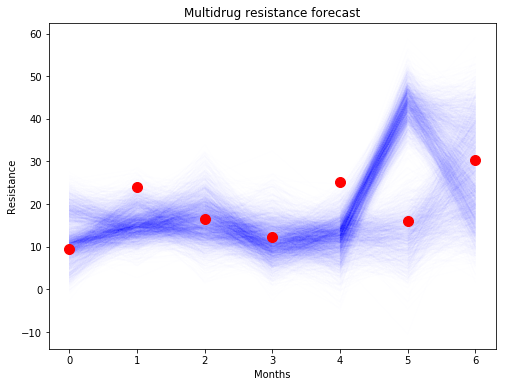

In [15]:
plot(Y_sample_DP, Y_test, "Multidrug resistance forecast","Multidrug")

# BDNN Erythromycin rescistance Forecasting 


In [16]:
param = [5.2e-01, 9.2e-01, 5.9e-01, 7.4e-01,
        1.8e+02, 7.0e+00, 1.0e-03]

In [17]:
features = Multidrug_X.shape[1]
x_batches, y_batches = get_time_series(Erythromycin_X, num_periods=num_periods, f_horizon=f_horizon)
X_test, Y_test = np.expand_dims(x_batches[-1,:,:],0), np.expand_dims(y_batches[-1,:,:],0)
x_batches, y_batches = x_batches[:-1,:,:], y_batches[:-1,:,:]
y_batches = np.expand_dims(y_batches[:,:,0],2)
Y_test = np.expand_dims(Y_test[:,:,0],2)

In [18]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, _, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,learning_rate=lr
                                                                              )
train(x_batches, y_batches, iterations=iterations,verbose = True, bs=bs)

0
Iteration 0, Mean squared errror: 2545.5778809
100
Iteration 100, Mean squared errror: 2088.2375488
200
Iteration 200, Mean squared errror: 1796.7010498
300
Iteration 300, Mean squared errror: 1689.5142822
400
Iteration 400, Mean squared errror: 1251.0111084
500
Iteration 500, Mean squared errror: 937.6160278
600
Iteration 600, Mean squared errror: 679.5099487
700
Iteration 700, Mean squared errror: 570.0811157
800
Iteration 800, Mean squared errror: 589.2503052
900
Iteration 900, Mean squared errror: 661.9874878
1000
Iteration 1000, Mean squared errror: 550.6928711
1100
Iteration 1100, Mean squared errror: 427.1923828
1200
Iteration 1200, Mean squared errror: 614.4475098
1300
Iteration 1300, Mean squared errror: 432.9921570
1400
Iteration 1400, Mean squared errror: 398.4810181
1500
Iteration 1500, Mean squared errror: 647.4989624
1600
Iteration 1600, Mean squared errror: 265.4150391
1700
Iteration 1700, Mean squared errror: 488.2254028
1800
Iteration 1800, Mean squared errror: 586.9

In [19]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, model_pred, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,learning_rate=lr
                                                                                       
                                                                                       )
Y_sample_DP = test(x_batches,X_test,features,samples, bs=bs,BN=BN)

INFO:tensorflow:Restoring parameters from temp/temp-bn-save


In [20]:
Y_sample_DP = np.expand_dims(Y_sample_DP[:,:,0],-1)
Y_test = np.expand_dims(Y_test[:,:,0],-1)

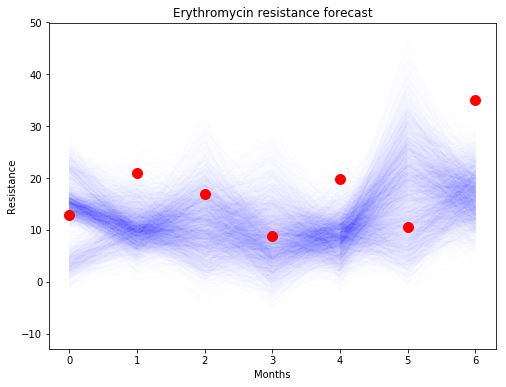

In [21]:
plot(Y_sample_DP, Y_test,"Erythromycin resistance forecast","Erythromycin")

# BDNN Pencillin rescistance Forecasting 


In [22]:
param = [7.8e-01, 8.4e-01, 5.5e-01, 9.9e-01,
        1.6e+02, 7.0e+00, 6.0e-04]

In [23]:
num_periods, f_horizon = 7, 1
decay=param[0]
bs = int(param[5])
dp_prob = np.array([param[1],param[2],param[3]])
BN=True
hidden= int(param[4])
samples = 3000
iterations=  5 * 1000
lr = param[6]

In [24]:
features = Multidrug_X.shape[1]
x_batches, y_batches = get_time_series(Pencillin_x, num_periods=num_periods, f_horizon=f_horizon)
X_test, Y_test = np.expand_dims(x_batches[-1,:,:],0), np.expand_dims(y_batches[-1,:,:],0)
x_batches, y_batches = x_batches[:-1,:,:], y_batches[:-1,:,:]
y_batches = np.expand_dims(y_batches[:,:,0],2)
Y_test = np.expand_dims(Y_test[:,:,0],2)

In [25]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, _, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,learning_rate=lr
                                                                              )
train(x_batches, y_batches, iterations=iterations,verbose = True, bs=bs)

0
Iteration 0, Mean squared errror: 4127.4956055
100
Iteration 100, Mean squared errror: 3617.7075195
200
Iteration 200, Mean squared errror: 2855.7229004
300
Iteration 300, Mean squared errror: 1596.8356934
400
Iteration 400, Mean squared errror: 791.8645630
500
Iteration 500, Mean squared errror: 475.4324036
600
Iteration 600, Mean squared errror: 297.0168152
700
Iteration 700, Mean squared errror: 461.6543274
800
Iteration 800, Mean squared errror: 346.4153137
900
Iteration 900, Mean squared errror: 371.1054077
1000
Iteration 1000, Mean squared errror: 302.5008850
1100
Iteration 1100, Mean squared errror: 249.0122986
1200
Iteration 1200, Mean squared errror: 229.9791718
1300
Iteration 1300, Mean squared errror: 229.0990295
1400
Iteration 1400, Mean squared errror: 248.4153748
1500
Iteration 1500, Mean squared errror: 352.7953796
1600
Iteration 1600, Mean squared errror: 161.2071533
1700
Iteration 1700, Mean squared errror: 259.8650818
1800
Iteration 1800, Mean squared errror: 262.66

In [26]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, model_pred, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,learning_rate=lr
                                                                                       
                                                                                       )
Y_sample_DP = test(x_batches,X_test,features,samples, bs=bs,BN=BN)

INFO:tensorflow:Restoring parameters from temp/temp-bn-save


In [27]:
Y_sample_DP = np.expand_dims(Y_sample_DP[:,:,0],-1)
Y_test = np.expand_dims(Y_test[:,:,0],-1)

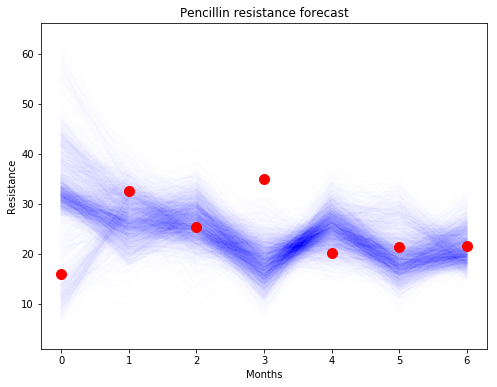

In [28]:
plot(Y_sample_DP, Y_test,"Pencillin resistance forecast","Pencillin")